In [1]:
import numpy as np
import pandas as pd

import pickle
import random

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb

from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import chi2_contingency
from statsmodels.stats.weightstats import zconfint

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.metrics import r2_score as r2

In [2]:
#!pip install xgboost
#!pip install Lightgbm
#!pip install catboost

In [3]:
data = pd.read_csv('course_project_train.csv')
test = pd.read_csv('course_project_test.csv')
data.head(15)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0
5,Rent,NaN,7 years,0.0,12.0,14.6,366784.0,0.0,NaN,0.0,other,Long Term,337304.0,165680.0,18692.0,NaN,1
6,Home Mortgage,1511108.0,10+ years,0.0,9.0,20.3,388124.0,0.0,73.0,0.0,home improvements,Short Term,99999999.0,51623.0,2317.0,745.0,0
7,Rent,1040060.0,10+ years,0.0,13.0,12.0,330374.0,0.0,18.0,0.0,other,Short Term,250888.0,89015.0,19761.0,705.0,1
8,Home Mortgage,NaN,5 years,0.0,17.0,15.7,0.0,1.0,NaN,1.0,home improvements,Short Term,129734.0,19.0,17.0,NaN,0
9,Home Mortgage,NaN,1 year,0.0,10.0,24.6,511302.0,0.0,6.0,0.0,debt consolidation,Long Term,572880.0,205333.0,17613.0,NaN,1


In [4]:
data.columns = data.columns.str.replace(' ', '_')
data.loc[data['Months_since_last_delinquent'].isnull(), ['Months_since_last_delinquent']]=0
data.loc[data['Years_in_current_job'].isnull(), 'Years_in_current_job'] = data['Years_in_current_job'].mode()[0]
data.loc[data['Bankruptcies']=='nan', 'Bankruptcies'] = data['Bankruptcies'].mode()[0]
data.loc[data['Current_Loan_Amount']>9000000,['Current_Loan_Amount']]=data['Current_Credit_Balance']
data.loc[data['Current_Loan_Amount']>9000000]

C:\Users\marty\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


,Home_Ownership,Annual_Income,Years_in_current_job,Tax_Liens,Number_of_Open_Accounts,Years_of_Credit_History,Maximum_Open_Credit,Number_of_Credit_Problems,Months_since_last_delinquent,Bankruptcies,Purpose,Term,Current_Loan_Amount,Current_Credit_Balance,Monthly_Debt,Credit_Score,Credit_Default


In [5]:
for cat_colname in data.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(data[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home_Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home_Ownership, dtype: int64
****************************************************************************************************

Years_in_current_job

10+ years    2703
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years_in_current_job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

In [6]:
for cat_colname in data.select_dtypes(include='object'):
    data = pd.concat([data, pd.get_dummies(data[cat_colname], prefix=cat_colname)], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 49 columns):
Home_Ownership                    7500 non-null object
Annual_Income                     5943 non-null float64
Years_in_current_job              7500 non-null object
Tax_Liens                         7500 non-null float64
Number_of_Open_Accounts           7500 non-null float64
Years_of_Credit_History           7500 non-null float64
Maximum_Open_Credit               7500 non-null float64
Number_of_Credit_Problems         7500 non-null float64
Months_since_last_delinquent      7500 non-null float64
Bankruptcies                      7486 non-null float64
Purpose                           7500 non-null object
Term                              7500 non-null object
Current_Loan_Amount               7500 non-null float64
Current_Credit_Balance            7500 non-null float64
Monthly_Debt                      7500 non-null float64
Credit_Score                      5943 non-null float64
C

In [7]:
data_short = data.drop(np.where(data.Credit_Score.isnull())[0])

In [8]:
income_pred = data.loc[data.Credit_Score.isnull()]
income_pred.drop(columns = ['Annual_Income'], inplace=True)
income_pred.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1557 entries, 5 to 7499
Data columns (total 48 columns):
Home_Ownership                    1557 non-null object
Years_in_current_job              1557 non-null object
Tax_Liens                         1557 non-null float64
Number_of_Open_Accounts           1557 non-null float64
Years_of_Credit_History           1557 non-null float64
Maximum_Open_Credit               1557 non-null float64
Number_of_Credit_Problems         1557 non-null float64
Months_since_last_delinquent      1557 non-null float64
Bankruptcies                      1555 non-null float64
Purpose                           1557 non-null object
Term                              1557 non-null object
Current_Loan_Amount               1557 non-null float64
Current_Credit_Balance            1557 non-null float64
Monthly_Debt                      1557 non-null float64
Credit_Score                      0 non-null float64
Credit_Default                    1557 non-null int64
Home_O

C:\Users\marty\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [9]:

#data.loc[data['Credit_Score'].isnull(), ['Credit_Score']]=0


In [10]:
#data.loc[data['Credit_Score']>5000, ['Credit_Score']] = data['Credit_Score']/10

In [11]:
#data.drop(columns = ['Number_of_Credit_Problems'], inplace=True)

In [12]:
#for colname in ['Bankruptcies']:
    #data_[colname] = data_[colname].astype(str)

In [13]:
#data.loc[data['Years_in_current_job'].isnull(), 'Years_in_current_job'] = data['Years_in_current_job'].mode()[0]
#data.loc[data['Bankruptcies']=='nan', 'Bankruptcies'] = data['Bankruptcies'].mode()[0]
#data.loc[data['Annual_Income'].isnull(), ['Annual_Income']]=0
#data.loc[data['Months_since_last_delinquent'].isnull(), ['Months_since_last_delinquent']]=0

In [14]:
#for cat_colname in data.select_dtypes(include='object').columns:
    #print(str(cat_colname) + '\n\n' + str(data[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

In [15]:
#for cat_colname in data_.select_dtypes(include='object'):
    #data_ = pd.concat([data_, pd.get_dummies(data_[cat_colname], prefix=cat_colname)], axis=1)
#data_.info()

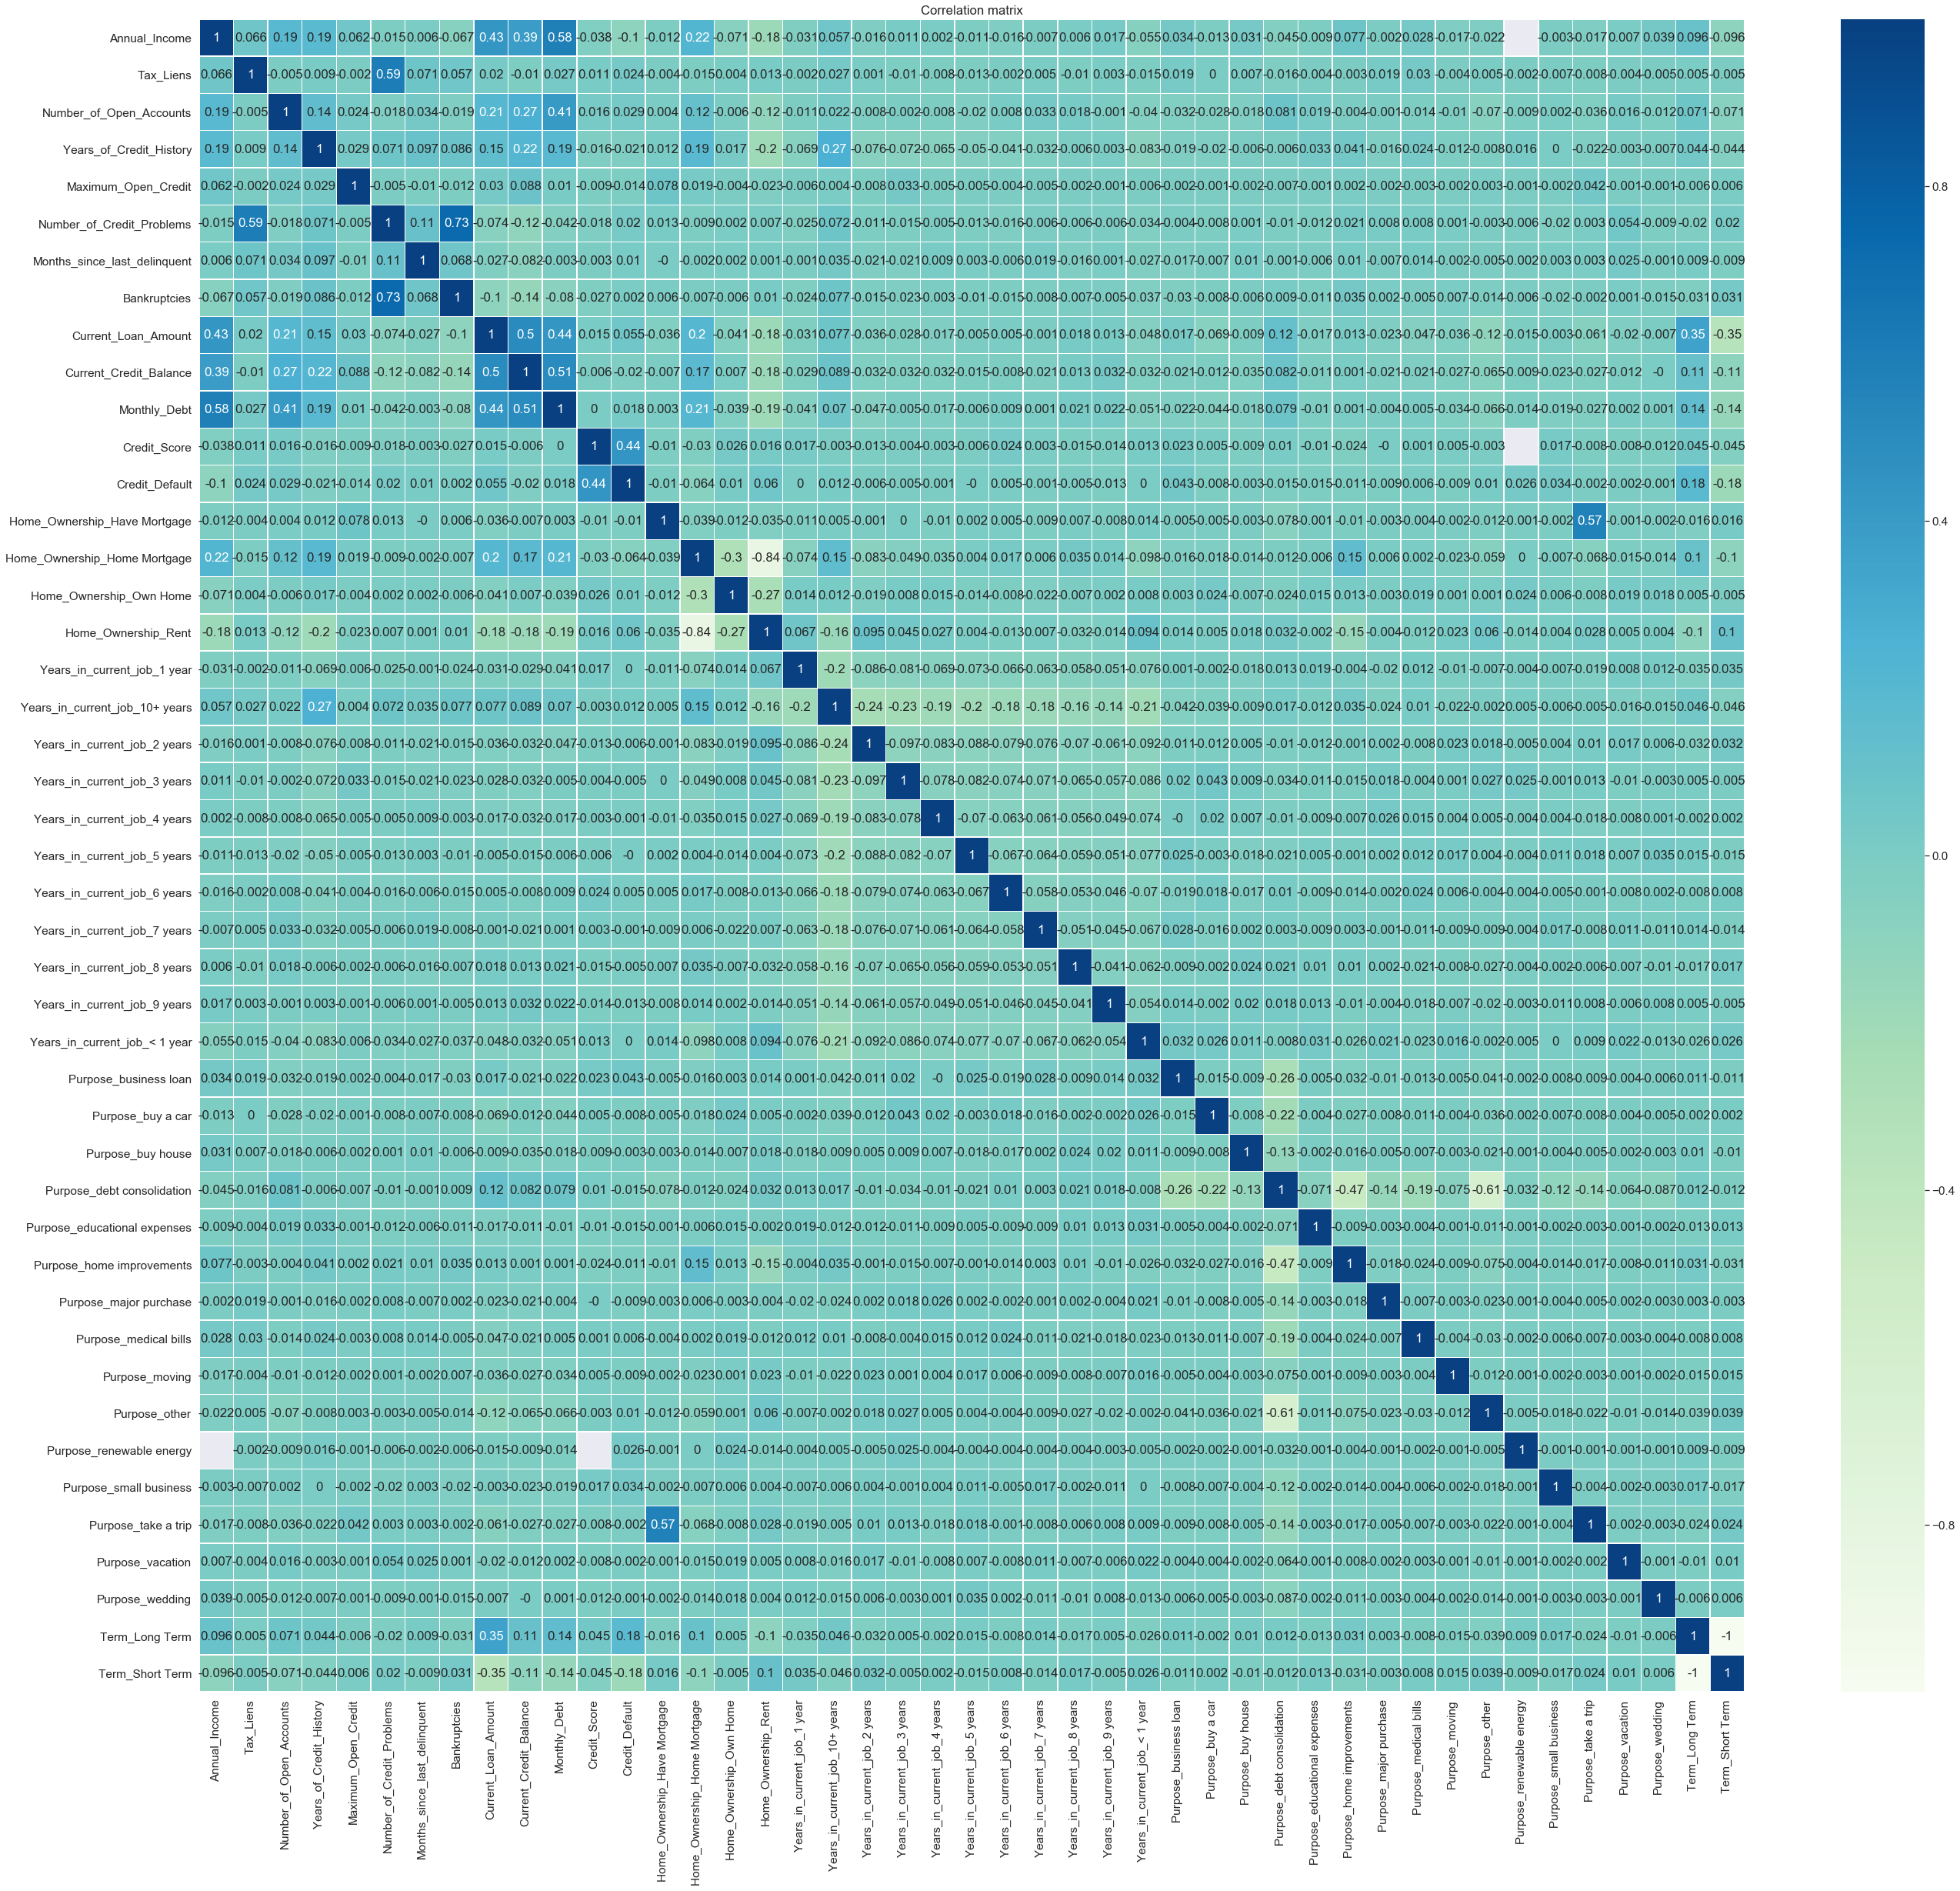

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 49 columns):
Home_Ownership                    7500 non-null object
Annual_Income                     5943 non-null float64
Years_in_current_job              7500 non-null object
Tax_Liens                         7500 non-null float64
Number_of_Open_Accounts           7500 non-null float64
Years_of_Credit_History           7500 non-null float64
Maximum_Open_Credit               7500 non-null float64
Number_of_Credit_Problems         7500 non-null float64
Months_since_last_delinquent      7500 non-null float64
Bankruptcies                      7486 non-null float64
Purpose                           7500 non-null object
Term                              7500 non-null object
Current_Loan_Amount               7500 non-null float64
Current_Credit_Balance            7500 non-null float64
Monthly_Debt                      7500 non-null float64
Credit_Score                      5943 non-null float64
C

In [16]:
plt.figure(figsize = (45,40))

sns.set(font_scale=1.4)
sns.heatmap(data.corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()
data.info()

In [17]:
#data_.loc[data_['Months_since_last_delinquent'].isnull(), ['Months_since_last_delinquent']]=0
#data_.loc[data['Years_in_current_job'].isnull(), 'Years_in_current_job'] = data['Years_in_current_job'].mode()[0]
#data_.loc[data['Bankruptcies']=='nan', 'Bankruptcies'] = data['Bankruptcies'].mode()[0]

#income_pred = data_.copy()
#income_pred = income_pred.loc[income_pred.Credit_Score.isnull()]
#income_pred.drop(columns = ['Annual_Income'], inplace=True)
#income_pred.info()
#df2 = df1.copy()

In [18]:
#data1 = data_.copy()
#data1.info()
#data1.head(153)
#data1.drop(np.where(data1.Annual_Income.isnull())[0])

In [19]:
train,valid=train_test_split(data_short,test_size=0.3, random_state=42)

In [20]:
feats=['Tax_Liens',
       'Number_of_Open_Accounts', 'Years_of_Credit_History',
       'Maximum_Open_Credit', 'Number_of_Credit_Problems',
       'Current_Loan_Amount', 'Current_Credit_Balance', 'Monthly_Debt',
        'Credit_Default', 'Home_Ownership_Have Mortgage',
       'Home_Ownership_Home Mortgage', 'Home_Ownership_Own Home',
       'Home_Ownership_Rent', 'Years_in_current_job_1 year',
       'Years_in_current_job_10+ years', 'Years_in_current_job_2 years',
       'Years_in_current_job_3 years', 'Years_in_current_job_4 years',
       'Years_in_current_job_5 years', 'Years_in_current_job_6 years',
       'Years_in_current_job_7 years', 'Years_in_current_job_8 years',
       'Years_in_current_job_9 years', 'Years_in_current_job_< 1 year',
       
       'Purpose_business loan', 'Purpose_buy a car', 'Purpose_buy house',
       'Purpose_debt consolidation', 'Purpose_educational expenses',
       'Purpose_home improvements', 'Purpose_major purchase',
       'Purpose_medical bills', 'Purpose_moving', 'Purpose_other',
       'Purpose_small business', 'Purpose_take a trip', 'Purpose_vacation',
       'Purpose_wedding', 'Term_Long Term', 'Term_Short Term']

In [21]:
model=RF(n_estimators=200,max_depth=8,max_features=15,random_state=42)

In [22]:
model.fit(train.loc[:,feats],train['Annual_Income'])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=8,
           max_features=15, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=200, n_jobs=None, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

In [23]:
y_pred=model.predict(valid.loc[:,feats])

In [24]:
r2(valid['Annual_Income'],y_pred)

0.41956831594490684

In [25]:
r2(train['Annual_Income'],model.predict(train.loc[:,feats]))

0.6760500255759159

In [26]:
income_pred['Annual_Income']=model.predict(income_pred.loc[:,feats])

C:\Users\marty\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [27]:
income_pred.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1557 entries, 5 to 7499
Data columns (total 49 columns):
Home_Ownership                    1557 non-null object
Years_in_current_job              1557 non-null object
Tax_Liens                         1557 non-null float64
Number_of_Open_Accounts           1557 non-null float64
Years_of_Credit_History           1557 non-null float64
Maximum_Open_Credit               1557 non-null float64
Number_of_Credit_Problems         1557 non-null float64
Months_since_last_delinquent      1557 non-null float64
Bankruptcies                      1555 non-null float64
Purpose                           1557 non-null object
Term                              1557 non-null object
Current_Loan_Amount               1557 non-null float64
Current_Credit_Balance            1557 non-null float64
Monthly_Debt                      1557 non-null float64
Credit_Score                      0 non-null float64
Credit_Default                    1557 non-null int64
Home_O

In [28]:
data_full =  pd.concat([data_short, income_pred])

C:\Users\marty\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [31]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7500 entries, 0 to 7499
Data columns (total 49 columns):
Annual_Income                     7500 non-null float64
Bankruptcies                      7486 non-null float64
Credit_Default                    7500 non-null int64
Credit_Score                      5943 non-null float64
Current_Credit_Balance            7500 non-null float64
Current_Loan_Amount               7500 non-null float64
Home_Ownership                    7500 non-null object
Home_Ownership_Have Mortgage      7500 non-null uint8
Home_Ownership_Home Mortgage      7500 non-null uint8
Home_Ownership_Own Home           7500 non-null uint8
Home_Ownership_Rent               7500 non-null uint8
Maximum_Open_Credit               7500 non-null float64
Monthly_Debt                      7500 non-null float64
Months_since_last_delinquent      7500 non-null float64
Number_of_Credit_Problems         7500 non-null float64
Number_of_Open_Accounts           7500 non-null float64
Purpose 

In [34]:
data_full.loc[data_full.Credit_Score.isnull(), ['Credit_Score']] = 0

In [36]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7500 entries, 0 to 7499
Data columns (total 49 columns):
Annual_Income                     7500 non-null float64
Bankruptcies                      7486 non-null float64
Credit_Default                    7500 non-null int64
Credit_Score                      7500 non-null float64
Current_Credit_Balance            7500 non-null float64
Current_Loan_Amount               7500 non-null float64
Home_Ownership                    7500 non-null object
Home_Ownership_Have Mortgage      7500 non-null uint8
Home_Ownership_Home Mortgage      7500 non-null uint8
Home_Ownership_Own Home           7500 non-null uint8
Home_Ownership_Rent               7500 non-null uint8
Maximum_Open_Credit               7500 non-null float64
Monthly_Debt                      7500 non-null float64
Months_since_last_delinquent      7500 non-null float64
Number_of_Credit_Problems         7500 non-null float64
Number_of_Open_Accounts           7500 non-null float64
Purpose 

In [37]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [38]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [43]:
TARGET_NAME = 'Credit_Default'
NUMERIC_FEATURE_NAMES = ['Annual_Income', 'Bankruptcies', 'Credit_Score', 'Current_Credit_Balance', 'Current_Loan_Amount', 'Maximum_Open_Credit', 'Monthly_Debt', 'Months_since_last_delinquent',
                         'Tax_Liens']
FEATURE_NAMES_SELECTED = ['Annual_Income', 'Bankruptcies', 'Credit_Score','Credit_Default',
       'Current_Credit_Balance', 'Current_Loan_Amount',
       'Home_Ownership_Have Mortgage', 'Home_Ownership_Home Mortgage',
       'Home_Ownership_Own Home', 'Home_Ownership_Rent', 'Maximum_Open_Credit',
       'Monthly_Debt', 'Months_since_last_delinquent',
       'Number_of_Credit_Problems', 'Number_of_Open_Accounts',
       'Purpose_business loan', 'Purpose_buy a car', 'Purpose_buy house',
       'Purpose_debt consolidation', 'Purpose_educational expenses',
       'Purpose_home improvements', 'Purpose_major purchase',
       'Purpose_medical bills', 'Purpose_moving', 'Purpose_other',
       'Purpose_renewable energy', 'Purpose_small business',
       'Purpose_take a trip', 'Purpose_vacation', 'Purpose_wedding',
       'Tax_Liens', 'Term_Long Term', 'Term_Short Term','Years_in_current_job_1 year',
       'Years_in_current_job_10+ years', 'Years_in_current_job_2 years',
       'Years_in_current_job_3 years', 'Years_in_current_job_4 years',
       'Years_in_current_job_5 years', 'Years_in_current_job_6 years',
       'Years_in_current_job_7 years', 'Years_in_current_job_8 years',
       'Years_in_current_job_9 years', 'Years_in_current_job_< 1 year',
       'Years_of_Credit_History']

In [44]:
scaler = StandardScaler()

df_norm = data_full.copy()
df_norm[NUMERIC_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUMERIC_FEATURE_NAMES])

df = df_norm.copy()

In [45]:
X = df[FEATURE_NAMES_SELECTED]
y = df[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.25, random_state=211)

In [46]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
df_balanced[TARGET_NAME].value_counts()

C:\Users\marty\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  """
C:\Users\marty\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  


0    4033
1    3184
Name: Credit_Default, dtype: int64

In [47]:
X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]

In [50]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.90      0.97      0.93      4033
           1       0.95      0.86      0.91      3184

   micro avg       0.92      0.92      0.92      7217
   macro avg       0.93      0.91      0.92      7217
weighted avg       0.92      0.92      0.92      7217

TEST

              precision    recall  f1-score   support

           0       0.80      0.87      0.83      1354
           1       0.56      0.43      0.49       521

   micro avg       0.75      0.75      0.75      1875
   macro avg       0.68      0.65      0.66      1875
weighted avg       0.73      0.75      0.74      1875

CONFUSION MATRIX

col_0            0.0  1.0
Credit_Default           
0               1178  176
1                295  226
